# Gender Pay Gap: Predicting income based on demographic data

## Abstract
What are the biggest indicators of a person's income? Their education level? Race? Gender? Age? What are demographic indicators that improve a woman's pay versus a man's?

For this project... 

## Introduction
As a teacher of underserved populations, I routinely tell my students that education is their greatest source of upward mobility.  In reality, I don't have data to support that assertion.  My biggest question is what demographic factors are most important in increasing a person's income, and just how wide is the income gap for women, minorities, and those with lower levels of education?  A person cannot change most of these indicators, as those are the cards they are dealt in life, but of the ones they can change, how much of an impact does this have on income?

The data I will be using is extacted from the [1994 census bureau database](http://www.census.gov/ftp/pub/DES/www/welcome.html).  This dataset contains census data from approximately 32,000 working people over the age of 16, who made over 100 dollars that year, and who are representative of the larger population.  For each of these people, the dataset tracks a person's age, native country, marital status, education, employment, capital gains and losses as well as the target variable, whether or not the person's income was over \$50,000 for that year.  Note that according to [Saving.org](https://www.saving.org/inflation/inflation.php?amount=50,000&year=1994), due to inflation and cost of living increases, this amount in 1994 would be worth approximately $84,500 in 2018.

### Research Questions
I will be attempting to answer the following questions:
- What demographic data is the best determinant for a person's income to be over \$50,000?
- Do those features differ between men and women?
- Do these features differe between white and non-white people?

### Models
To answer these questions, I will be using random forests, support vector machine classifier models, and logistic regression models.

## Imports

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', color_codes=True)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Statistics
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Cross validation 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Timer
import time
from scipy.special import expit

## Uploading, Cleaning, and Describing Data

In [2]:
# Column names from source documentation, and data separated by column and space
inc_raw = pd.read_csv('adult.data.csv', header=None, sep=', ',
                      names=['age','workclass','fnlwgt','education','education_num','marital_status',
                             'occupation','relationship','race','sex','capital_gain',
                            'capital_loss','hours_per_week','native_country','income'])
inc_raw.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
inc_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Based on this information, none of the columns have null values, and while 6 of the column entries are integer values, 9 of the column entries are categorical in nature.  Now, I will inspect the number of unique entries for each column to get a better sense of the data.

In [4]:
inc_raw.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education_num        16
marital_status        7
occupation           15
relationship          6
race                  5
sex                   2
capital_gain        119
capital_loss         92
hours_per_week       94
native_country       42
income                2
dtype: int64

Some initial observations I had while inspecting the number of unique entries:
- The final weight column has the most unique values.  This column represents the number of people that an entry could represent.  This makes sense as to why this number is so large, because there is a large spread in the number of people who are similar to an entry.  In my analysis, I am not trying to model proportions of the population or total values for the population, I will drop this column from the data set.
- The education and education number columns both have 16 unique values.  This is because the level of education is represented numerically by the education number column.  I will inspect this further, but will only use one column in my analysis.
- There are 7 different marital status types, but 6 relationshp status types.  This is worth looking further into. 
- Capital gains and capital losses have a limited number of unique entries.  I would have expected more.  This tells me that there aren't many people who reported capital gains or losses this year. 
- A person's native country has 42 possible entries.  If I want to analyze this data based on immigrant status or race, I will likely need to make this category more broad. 

First, let's remove the final weight column from the data set.

In [5]:
inc = inc_raw.drop('fnlwgt', axis=1)

Now, let's inspect the different values in each of the columns to get a better sense of what each column is describing and clean the data where necessary.

In [6]:
inc.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

This data set is very skewed in favor of employees of the private sector.  This makes sense because most of the work force is a part of the private sector.  There are also a good number of people employed by various governmnent entities, self-employed, and a small number either without pay or never worked.  I will combine this column into four more generalized groups:
- Private
- Government (including those employed by Local, State, and Federal Governments)
- Self-employed (including incorporated or non-incorporated entrepreneurs)  
- Not working  (including those working without pay and who never worked in the year)

There is also about 5% of the data that has unknown working class. I will drop these entries because it is impossible to impute the data or take the mean of the type of work, and these make up such a small portion of the data, so should not impact the overall analysis.

In [7]:
# Creating new data frame with updated working class categories
inc = inc[inc['workclass'] != '?']
inc.workclass = inc.workclass.map({'Private':'Private',
                                   'Self-emp-not-inc':'Self_employed','Self-emp-inc':'Self_employed',
                                    'Local-gov':'Government', 'State-gov':'Government', 'Federal-gov':'Government',
                                    'Without-pay':'Not_working', 'Never-worked':'Not_working'})
inc.workclass.value_counts()

Private          22696
Government        4351
Self_employed     3657
Not_working         21
Name: workclass, dtype: int64

Great! Next, let's inspect the education number to make sure that maps to the categorical education column.

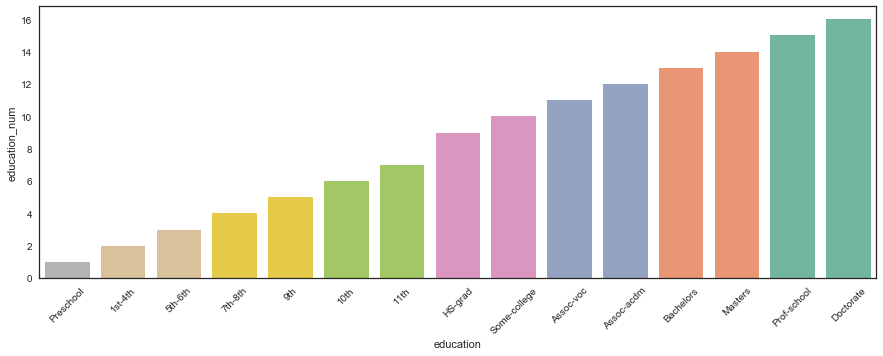

In [8]:
# First, establish estimated order of education, then plot
edu_order = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','HS-grad','Some-college',
            'Assoc-voc','Assoc-acdm','Bachelors','Masters','Prof-school','Doctorate']
plt.figure(figsize=(15,5))
sns.barplot(x='education', y='education_num', data=inc, palette='Set2_r', order=edu_order)
plt.xticks(rotation=45)
plt.show()

Yes, because there are no error bars on our plot, this indicates that education number indeed is directly correlated with the level of education.  Education number is an ordinal scale representing level of education because it doesn't indicate number of years of schooling, but rather the order of level achieved.  For our analyses, we will need either continuous or categorical dummies, so we will drop the education number column and later create dummies assuming we want this as a feature in our models.

In [9]:
# Dropping Numerical Education column
inc = inc.drop('education_num', axis=1)

inc.education.value_counts()

HS-grad         9969
Some-college    6777
Bachelors       5182
Masters         1675
Assoc-voc       1321
11th            1057
Assoc-acdm      1020
10th             833
7th-8th          574
Prof-school      558
9th              463
Doctorate        398
12th             393
5th-6th          303
1st-4th          156
Preschool         46
Name: education, dtype: int64

Now there are a lot of categories with just a few people in them.  Let's generalize these categories to be the following:
- Dropouts (all people who did not complete high school)
- High School Graduates
- Some College (people who attended college, and those who earned Associates Degrees)
- Bachelors Degrees
- Advanced Degrees (including all people who earned Masters, Professional Degrees, or Doctorates)

In [10]:
# Re-naming entries to generalize some of the smaller categories
inc.education = inc.education.map({'Preschool':'Dropout',
                                   '1st-4th':'Dropout',
                                   '5th-6th':'Dropout',
                                   '7th-8th':'Dropout',
                                   '9th':'Dropout',
                                   '10th':'Dropout',
                                   '11th':'Dropout',
                                   'HS-grad':'HS-grad',
                                   'Some-college':'Some-college',
                                   'Assoc-voc':'Some-college',
                                   'Assoc-acdm':'Some-college',
                                   'Bachelors':'Bachelors',
                                   'Masters':'Advanced-degree',
                                   'Prof-school':'Advanced-degree',
                                   'Doctorate':'Advanced-degree'})
inc.education.value_counts()

HS-grad            9969
Some-college       9118
Bachelors          5182
Dropout            3432
Advanced-degree    2631
Name: education, dtype: int64

Next, let's check out marital status and the different options in this column.

In [11]:
inc.marital_status.value_counts()

Married-civ-spouse       14340
Never-married             9917
Divorced                  4259
Separated                  959
Widowed                    840
Married-spouse-absent      389
Married-AF-spouse           21
Name: marital_status, dtype: int64

Again, it looks like the majority of people are either married to civilians or never married, with a strong portion of people who were married but are now divorced. There are then people in categories with fewer people. These can be combined into three overall categories: 
- Never married
- Married (including married to a civilian spouse, and married to a spouse in the Armed Forces)
- No Longer Married (including divorced, separated, married to an absent spouse, and widowed)

In [12]:
inc.marital_status = inc.marital_status.map({'Married-civ-spouse':'Married', 'Married-AF-spouse':'Married',
                                             'Divorced':'No_longer_married', 'Separated':'No_longer_married',
                                             'Married-spouse-absent':'No_longer_married', 'Widowed':'No_longer_married',
                                            'Never-married':'Never-married'})
inc.marital_status.value_counts()

Married              14361
Never-married         9917
No_longer_married     6447
Name: marital_status, dtype: int64

Next, let's inspect the occupation options in this data set.

In [13]:
inc.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
?                       7
Name: occupation, dtype: int64

It looks like there are still 7 people with unknown occupations.  I will drop these from the data set.  Otherwise, these categories are fairly distinct and, for the most part, individuals are evenly spread across all categories.  I will leave the rest as is for now, but I will keep in mind that there are a high number of different categories in this column that might be able to be condensed if needed.

In [14]:
inc = inc[inc.occupation != '?']

Next, we have the relationship column.  From the head of the Data Frame, it is unclear what this column represents, but I will inspect the value counts in this column.

In [15]:
inc.relationship.value_counts()

Husband           12704
Not-in-family      7865
Own-child          4525
Unmarried          3271
Wife               1435
Other-relative      918
Name: relationship, dtype: int64

I'm unsure what these values mean for any given person.  For this reason, I will drop this column from the data set.

In [16]:
inc = inc.drop('relationship', axis=1)

Next, I'll inspect the race column for its values.

In [17]:
print(inc.race.value_counts())

White                 26301
Black                  2909
Asian-Pac-Islander      974
Amer-Indian-Eskimo      286
Other                   248
Name: race, dtype: int64


As expected, there is a higher number of people who are white than other minority races.  To reduce this class imbalance, I will simplify this column into white and non-white populations.

In [18]:
inc.race = inc.race.map({'White':'White', 'Black':'Non-White','Asian-Pac-Islander':'Non-White',
                        'Amer-Indian-Eskimo':'Non-White','Other':'Non-White'})
inc.race.value_counts()

White        26301
Non-White     4417
Name: race, dtype: int64

The sex column has two unique values, male and female.  We will leave this and continue on to capital gain and capital loss.

In [19]:
print('Summary of Capital Gains:')
print(inc.capital_gain.describe())
print('\nSummary of Capital Losses:')
print(inc.capital_loss.describe())

Summary of Capital Gains:
count    30718.000000
mean      1106.037079
std       7497.863364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

Summary of Capital Losses:
count    30718.000000
mean        88.910216
std        405.657203
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64


Wow! Most people reported no capital gains or losses. The maximum capital gain is \$99,999, or else this is a mistake. The largest capital loss is only \$4,356. Let's inspect the maximum value of capital gains and how capital gains and capital losses are related to one another.

In [20]:
print('Number of Entries with Capital Gain of $99,999:', len(inc[inc.capital_gain >= 99999]))
inc[inc.capital_gain >= 99999].head()

Number of Entries with Capital Gain of $99,999: 155


,age,workclass,education,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1246,54,Self_employed,Advanced-degree,Married,Prof-specialty,White,Male,99999,0,60,United-States,>50K
1368,52,Private,HS-grad,Married,Exec-managerial,Non-White,Male,99999,0,40,Japan,>50K
1482,53,Self_employed,HS-grad,Married,Sales,White,Male,99999,0,40,United-States,>50K
1528,52,Private,Bachelors,Married,Exec-managerial,White,Male,99999,0,50,United-States,>50K
1616,46,Private,Advanced-degree,Married,Prof-specialty,White,Male,99999,0,60,United-States,>50K


There are 155 entries where the capital gains are \$99,999.  These all coincide with the income value of over \$50,000, making these values plausible.  For now, I will keep these plausible entries, but I will keep in mind that there is this set of outliers in capital gains, and I will consider turning this column into a categorical variable with bins to capture the differences in capital gains. 

Now, let's take a look at the largest values of capital losses.

In [21]:
inc[inc.capital_loss >= 3500]

,age,workclass,education,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
11902,34,Private,HS-grad,No_longer_married,Other-service,White,Female,0,3770,45,United-States,<=50K
12600,74,Government,Advanced-degree,Never-married,Prof-specialty,White,Female,0,3683,20,United-States,>50K
14756,82,Private,HS-grad,No_longer_married,Exec-managerial,White,Female,0,4356,18,United-States,<=50K
15942,38,Private,Dropout,No_longer_married,Adm-clerical,White,Male,0,3770,40,United-States,<=50K
20416,54,Private,Dropout,No_longer_married,Machine-op-inspct,White,Female,0,3900,40,United-States,<=50K
23054,68,Government,HS-grad,No_longer_married,Prof-specialty,White,Female,0,3683,40,United-States,<=50K
23802,41,Private,Some-college,No_longer_married,Prof-specialty,White,Female,0,3900,40,United-States,<=50K


It looks like these values are reasonable, and, again, down the line I will consider binning this variable if impactful for the model.

Next, let's make sure that hours per week look reasonable.

In [22]:
inc.hours_per_week.describe()

count    30718.000000
mean        40.949313
std         11.985382
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64

As expected for the United States, the mean hours per week is just over 40 hours per week.  Interestingly, the minimum is 1 hour per week, and the maximum is 99 hours per week.  Let's take a look at those two cases to ensure that those are valid data points.

In [23]:
inc[inc.hours_per_week == 1]

,age,workclass,education,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
189,58,Government,Advanced-degree,Married,Prof-specialty,White,Male,0,0,1,United-States,>50K
1036,66,Self_employed,Dropout,Married,Exec-managerial,White,Male,1409,0,1,?,<=50K
11451,27,Private,HS-grad,Never-married,Machine-op-inspct,White,Male,0,0,1,United-States,<=50K
19750,23,Private,HS-grad,Never-married,Craft-repair,Non-White,Male,0,0,1,Vietnam,<=50K
20909,77,Self_employed,Some-college,No_longer_married,Adm-clerical,White,Female,0,1944,1,United-States,<=50K
22960,21,Private,HS-grad,Never-married,Machine-op-inspct,Non-White,Male,0,0,1,United-States,<=50K
24284,57,Self_employed,HS-grad,Married,Exec-managerial,White,Male,0,0,1,United-States,<=50K
25078,74,Private,Dropout,No_longer_married,Other-service,White,Female,0,0,1,United-States,<=50K


In [24]:
print('Number of people who work 99 hours per week:', len(inc[inc.hours_per_week ==99]))
inc[inc.hours_per_week ==99].head()

Number of people who work 99 hours per week: 80


,age,workclass,education,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
935,37,Private,HS-grad,Married,Craft-repair,White,Male,0,0,99,United-States,>50K
1172,25,Private,Advanced-degree,Married,Farming-fishing,White,Male,0,0,99,United-States,>50K
1887,55,Self_employed,Some-college,Married,Farming-fishing,White,Male,0,0,99,United-States,>50K
3578,37,Self_employed,Advanced-degree,Married,Prof-specialty,Non-White,Male,0,0,99,United-States,>50K
4308,35,Self_employed,HS-grad,Married,Farming-fishing,White,Male,0,0,99,United-States,<=50K


All of these seem like reasonable entries, for both the low and high values.  Again, I will consider binning this column if needed for modeling. 

Finally, let's inspect the native country of people.

In [25]:
inc.native_country.value_counts()

United-States                 27504
Mexico                          610
?                               556
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
India                           100
El-Salvador                     100
Cuba                             92
England                          86
Jamaica                          80
South                            71
Italy                            68
China                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        63
Japan                            59
Columbia                         56
Poland                           56
Haiti                            42
Iran                             42
Taiwan                           42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                      

Unsurprisingly, the majority of people in this census are native to the United States. The number and imbalance of this column could pose a problem.  I will categorize these into general geographic locations. Note, I placed Canada in the European category because of its French and English influences.   I will also remove the less than 600 entries that are missing this information.

In [26]:
inc = inc[inc.native_country != '?']
inc.native_country = inc.native_country.map({'United-States':'United_States', 
                                             'Cuba':'Latin_Am', 
                                             'Jamaica':'Latin_Am',
                                             'India':'Asia', 
                                             'Mexico':'Latin_Am',
                                             'Puerto-Rico':'Latin_Am', 
                                             'Honduras':'Latin_Am', 
                                             'England':'Europe',
                                             'Canada':'Europe', 
                                             'Germany':'Europe', 
                                             'Iran':'Asia',
                                             'Philippines':'Asia', 
                                             'Poland':'Europe', 
                                             'Columbia':'Latin_Am', 
                                             'Cambodia':'Asia', 
                                             'Thailand':'Asia',
                                             'Ecuador':'Latin_Am', 
                                             'Laos':'Asia',
                                             'Taiwan':'Asia', 
                                             'Haiti':'Latin_Am', 
                                             'Portugal':'Europe',
                                             'Dominican-Republic':'Latin_Am', 
                                             'El-Salvador':'Latin_Am', 
                                             'France':'Europe', 
                                             'Guatemala':'Latin_Am',
                                             'Italy':'Europe', 
                                             'China':'Asia',
                                             'South':'Latin_Am', 
                                             'Japan':'Asia', 
                                             'Yugoslavia':'Europe', 
                                             'Peru':'Latin_Am',
                                             'Outlying-US(Guam-USVI-etc)':'United_States', 
                                             'Scotland':'Europe', 
                                             'Trinadad&Tobago':'Latin_Am',
                                             'Greece':'Europe', 
                                             'Nicaragua':'Latin_Am', 
                                             'Vietnam':'Asia', 
                                             'Hong':'Asia', 
                                             'Ireland':'Europe', 
                                             'Hungary':'Europe',
                                             'Holand-Netherlands':'Europe'})
inc.native_country.value_counts()

United_States    27518
Latin_Am          1410
Asia               634
Europe             600
Name: native_country, dtype: int64

Finally, let's change our target varible, income greater or less than \$50,000 to a binary variable where income less than \$50,000 is 0, and income greater than $50,000 is 1.

In [27]:
inc.income = inc.income.map({'>50K': 1, '<=50K': 0})
inc.head()

,age,workclass,education,marital_status,occupation,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,Government,Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,United_States,0
1,50,Self_employed,Bachelors,Married,Exec-managerial,White,Male,0,0,13,United_States,0
2,38,Private,HS-grad,No_longer_married,Handlers-cleaners,White,Male,0,0,40,United_States,0
3,53,Private,Dropout,Married,Handlers-cleaners,Non-White,Male,0,0,40,United_States,0
4,28,Private,Bachelors,Married,Prof-specialty,Non-White,Female,0,0,40,Latin_Am,0


Now that our data has been cleaned and wrangled, I will perform Exploratory Data Analysis to identify patterns and trends in the data.

## Exploratory Data Analysis

I will start by inspecting the distribution of income across the data set.

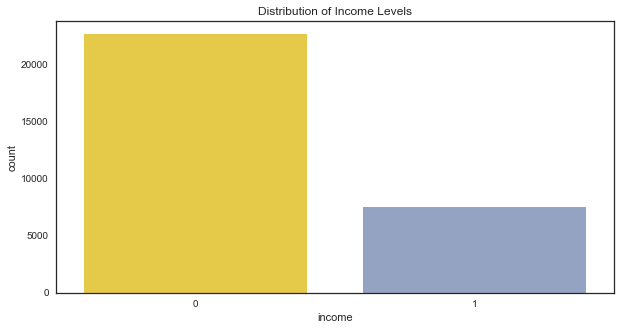

Percent of Low Income: 75.92%


In [28]:
plt.figure(figsize=(10,5))
sns.countplot(x='income', data=inc, palette='Set2_r')
plt.title('Distribution of Income Levels')
plt.show()

print('Percent of Low Income: {:.2f}%'.format(len(inc_raw[inc_raw.income == '<=50K'])/len(inc_raw)*100))

76% of people have an income below \$50,000. There are more people that earn under \$50,000 per year, than people who don't. This means that I have a class imbalance and will need to consider under- or over-sampling in my modeling.

Next I will visualize the distribution of each of these variables, along with the distribution of income levels for each variable. 

					***** WORKCLASS *****


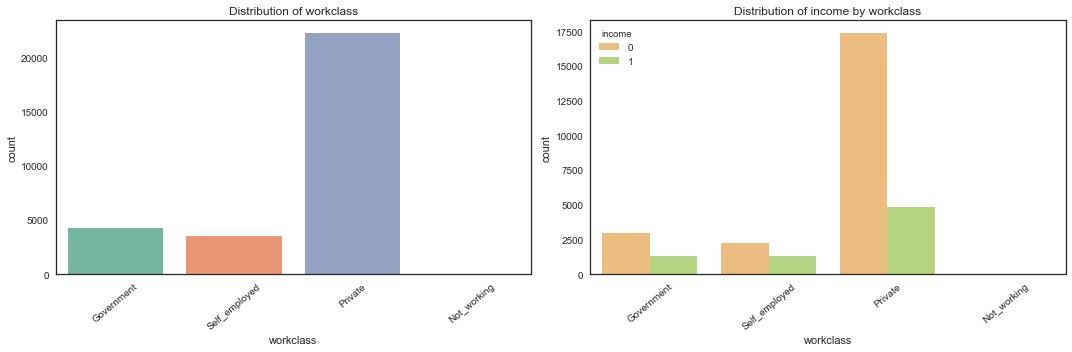

income             0     1
workclass                 
Government      2971  1318
Not_working       14     0
Private        17410  4876
Self_employed   2259  1314
					***** EDUCATION *****


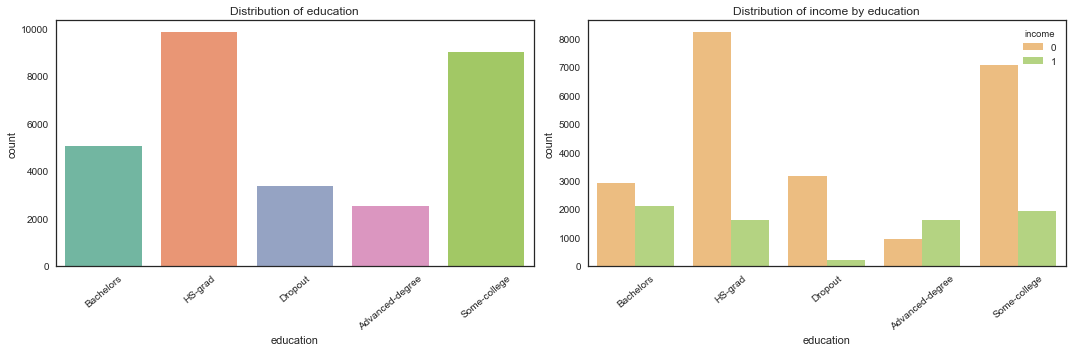

income              0     1
education                  
Advanced-degree   940  1604
Bachelors        2918  2126
Dropout          3168   196
HS-grad          8223  1617
Some-college     7057  1936
					***** MARITAL_STATUS *****


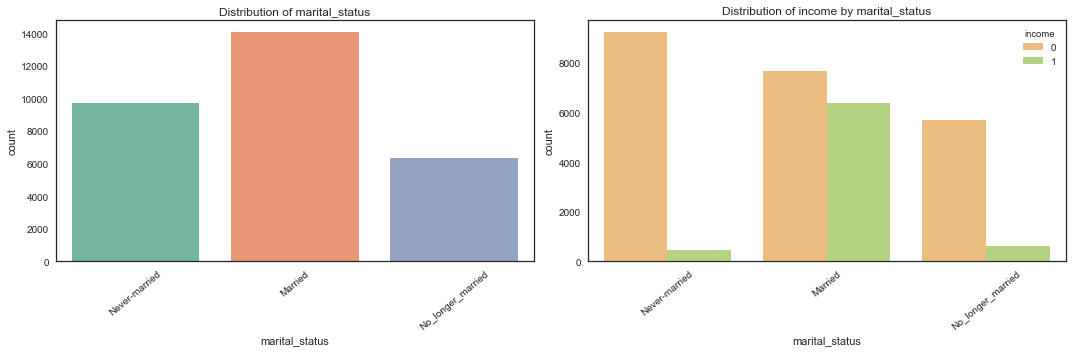

income                0     1
marital_status               
Married            7677  6409
Never-married      9256   470
No_longer_married  5721   629
					***** OCCUPATION *****


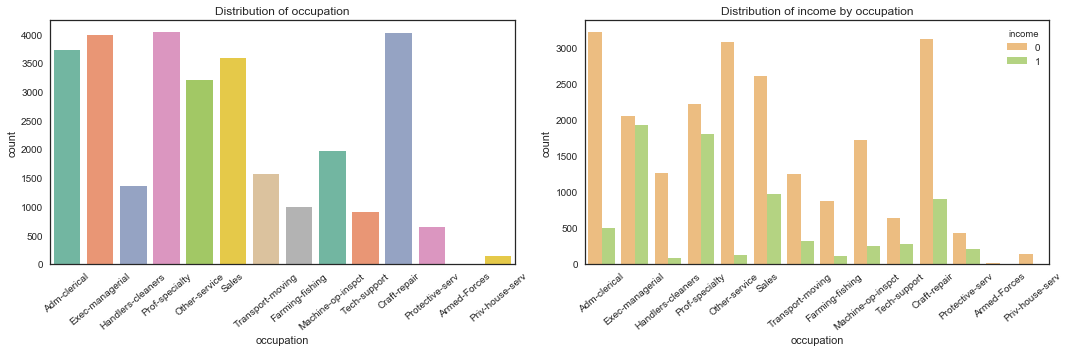

income                0     1
occupation                   
Adm-clerical       3223   498
Armed-Forces          8     1
Craft-repair       3122   908
Exec-managerial    2055  1937
Farming-fishing     874   115
Handlers-cleaners  1267    83
Machine-op-inspct  1721   245
Other-service      3080   132
Priv-house-serv     142     1
Prof-specialty     2227  1811
Protective-serv     434   210
Sales              2614   970
Tech-support        634   278
Transport-moving   1253   319
					***** RACE *****


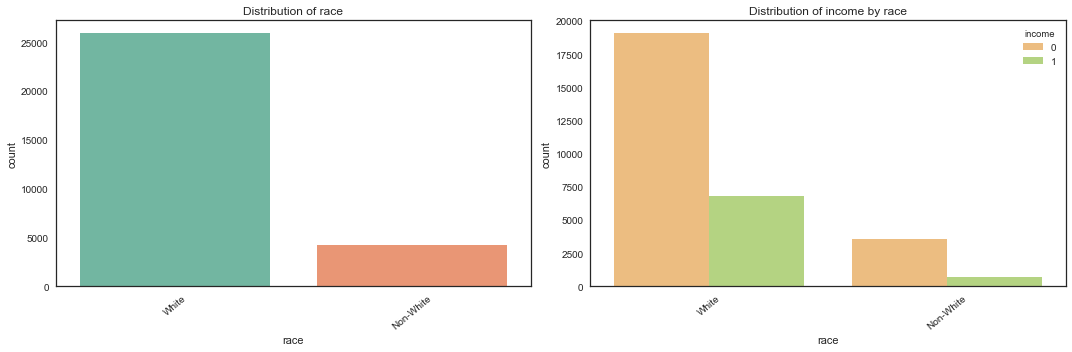

income         0     1
race                  
Non-White   3560   669
White      19094  6839
					***** SEX *****


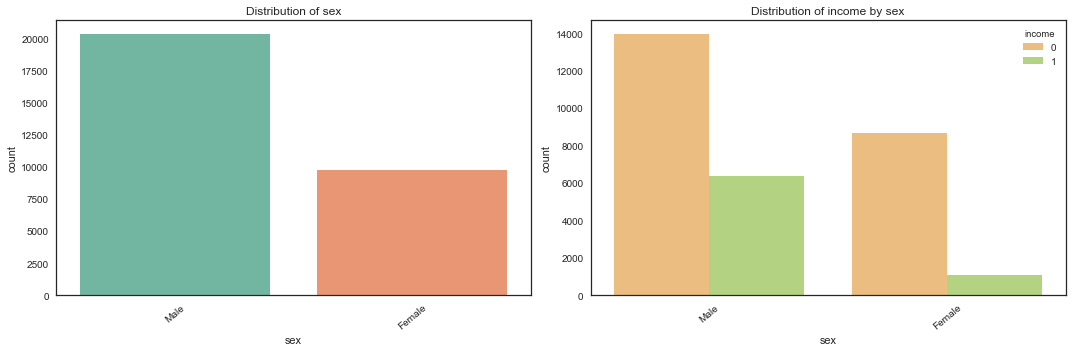

income      0     1
sex                
Female   8670  1112
Male    13984  6396
					***** NATIVE_COUNTRY *****


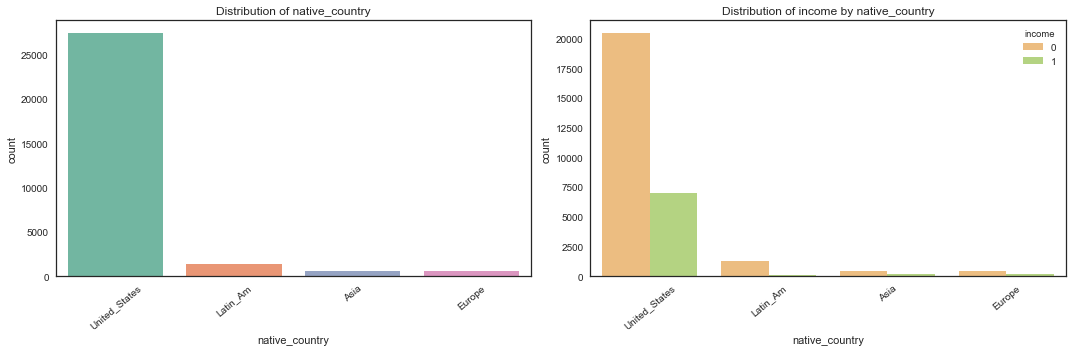

income              0     1
native_country             
Asia              431   203
Europe            415   185
Latin_Am         1285   125
United_States   20523  6995


,Attribute,P_value
1,education,0.000000e+00
2,marital_status,0.000000e+00
3,occupation,0.000000e+00
5,sex,5.862415e-310
0,workclass,1.406662e-99
4,race,5.076837e-49
6,native_country,8.442885e-49


In [29]:
# Initializing data frame for p-values from Chi-Square test
p_vals = pd.DataFrame(columns=['Attribute', 'P_value'])

for col in inc.select_dtypes(include='object').columns:
    print('\t\t\t\t\t***** {} *****'.format(col.upper()))
    # Plotting counts of each column
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.countplot(x=col, data=inc, palette='Set2')
    plt.title('Distribution of {}'.format(col))
    plt.xticks(rotation=40)

    # Plotting counts of each column by income level
    plt.subplot(122)
    sns.countplot(x=col, data=inc, hue='income', palette='RdYlGn')
    plt.title('Distribution of income by {}'.format(col))
    plt.xticks(rotation=40)
    
    plt.tight_layout()
    plt.show()

    # Creating cross tabulated data for Chi-square test
    counttable = pd.crosstab(inc[col], inc['income'])
    print(counttable)
    chi2, p, dof, ex = chi2_contingency(counttable, correction=False)
    p_vals = p_vals.append({'Attribute':col, 'P_value':float(p)}, ignore_index=True)
    

# Printing p-values of Chi-squared tests, sorted by p-values
p_vals.sort_values('P_value')

Here, we visualize the similar class imbalances we observed in cleaning the data, especially in working class, education, race, and native country.  We also visualize that there are more people who earn less than \$50,000 in the majority of categories, regardless of their demographics.  Despite this, there are a number of demographic attributes that result in a higher proportion of individuals earning over \$50,000.  Those attributes are as follows:

- Having a Bachelor's degree, or other advanced degree
- Being married
- Working as an executive manager or in a professional specialty

According to the p-values from the chi-squared tests, all categorical values have significant differences (p-value < 0.05) between populations earning high and low incomes.  This means that all of these demographic attributes have some relationship with income level, and will therefore be included as potential features in our modeling. 

Next, let's take a look at distributions of continuous data for income levels.

					***** AGE *****


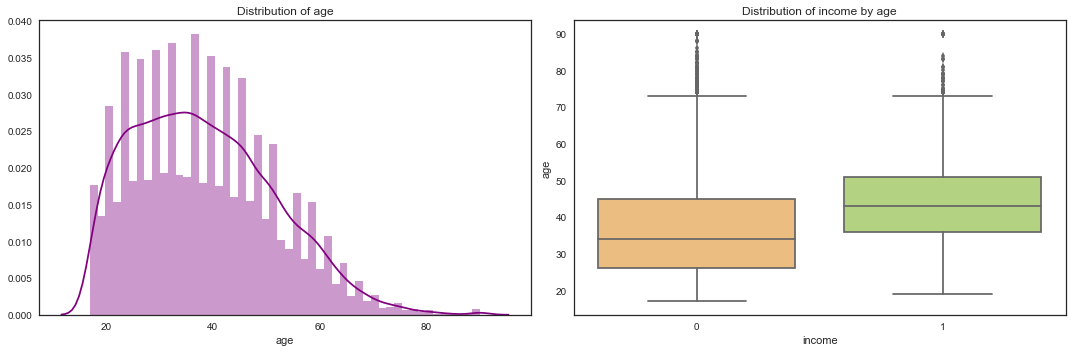

					***** CAPITAL_GAIN *****


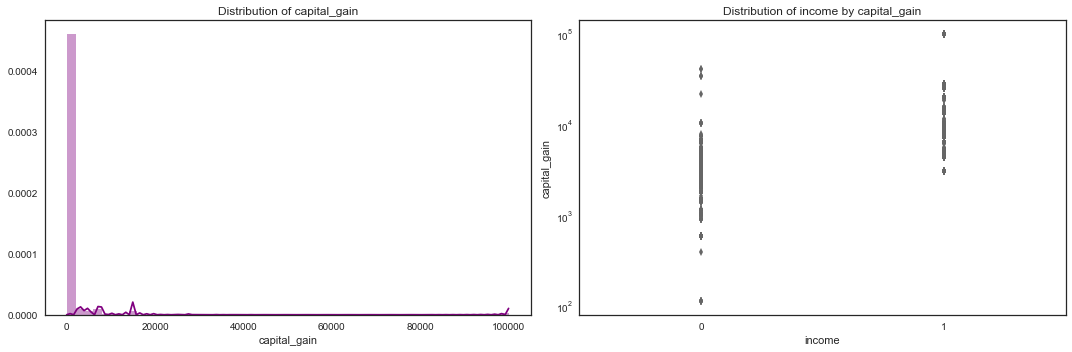

					***** CAPITAL_LOSS *****


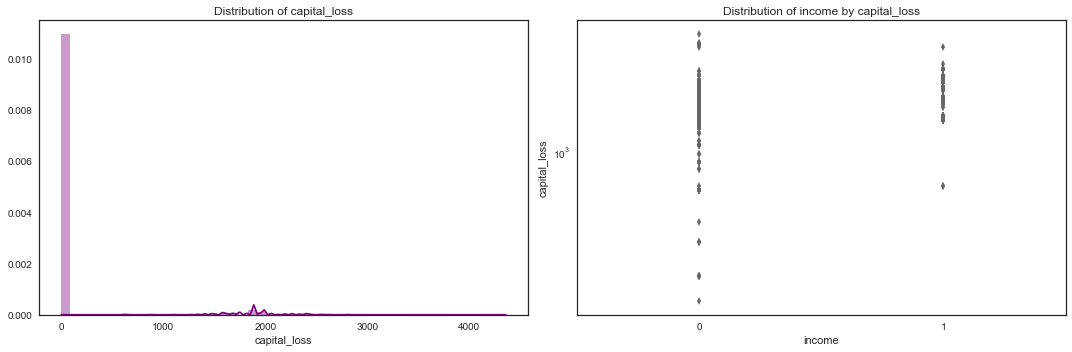

					***** HOURS_PER_WEEK *****


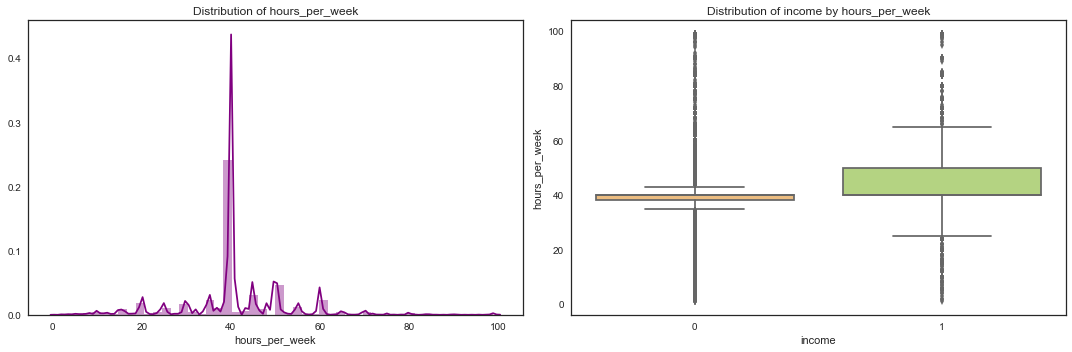

,Attribute,P_value
0,age,0.000000e+00
1,capital_gain,0.000000e+00
3,hours_per_week,0.000000e+00
2,capital_loss,2.182812e-151


In [30]:
# Initializing data frame for p-values from Chi-Square test
p_vals = pd.DataFrame(columns=['Attribute', 'P_value'])

for col in inc.select_dtypes(include='int64').columns.drop('income'):
    print('\t\t\t\t\t***** {} *****'.format(col.upper()))
    # Plotting distributions of each column
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(inc[col], color='Purple')
    plt.title('Distribution of {}'.format(col))

    # Plotting distributions of each column by income level
    plt.subplot(122)
    sns.boxplot(x='income', y=col, data=inc, palette='RdYlGn')
    plt.title('Distribution of income by {}'.format(col))
    #changing y-axis scale to log for capital gain and capital loss to better visualize distribution
    if col in ['capital_gain','capital_loss']:
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

    # Calculating pvalues from t-test
    t_val, p_val = ttest_ind(inc[inc['income']==0][col],
                                inc[inc['income']==1][col])
    p_vals = p_vals.append({'Attribute':col, 'P_value':float(p_val)}, ignore_index=True)
    

# Printing p-values of t-tests, sorted by p-values
p_vals.sort_values('P_value')

According to the data, all of the continuous variables have significant differences (p-value <0.05) between the distributions of high and low incomes.  Additionally, there are a number of observations we can make from these boxplots:
- Older people are more likely to earn more than \$50,000
- Most people had zero capital gains and capital losses
- The majority of people worked just over 40 hours per week
- People who earned more than \$50,000 worked, on average, longer than 40 hours per week

One assumption of the models I am going to develop is that continuous features are normally distributed.  Based on the plots above:
- Age is slightly skewed right with a tail contining older people in the population.  This is also likely because all people younger than 16 were not included in the data set in the first place.  
- Capital gains and capital losses are both strongly skewed right.  Because of this skew, I will use the values as is and also bin the values into categories and determine how this impacts model accuracy.
- Hours per week is centered around 40, a left skew of spikes on either side of the center.

Based on these observations, I will need to engineer age, capital gains, and hours per week to be normally distributed.

## Feature Selection and Engineering
Next, I will use all potential features from this data set to select features to include in our modeling.  

In [31]:
# Creating dummy variables for categorical features
dummies = pd.get_dummies(inc.select_dtypes(include='object'))
dummies.head()

,workclass_Government,workclass_Not_working,workclass_Private,workclass_Self_employed,education_Advanced-degree,education_Bachelors,education_Dropout,education_HS-grad,education_Some-college,marital_status_Married,...,occupation_Tech-support,occupation_Transport-moving,race_Non-White,race_White,sex_Female,sex_Male,native_country_Asia,native_country_Europe,native_country_Latin_Am,native_country_United_States
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
3,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0


Now that I have a basic set of dummy features for categorical variables, I need to ensure that the age and hours per week variables are normally distributed.  To do this, I will create a four-panel plot for each to transform each variable through log, square root, and cube root, and plotting the histograms of these values to determine which transformation is most normally distributed. 

		*****Four-panel Plot for age*****


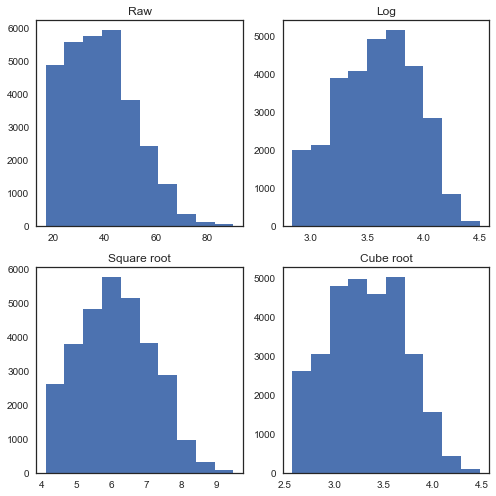

		*****Four-panel Plot for hours_per_week*****


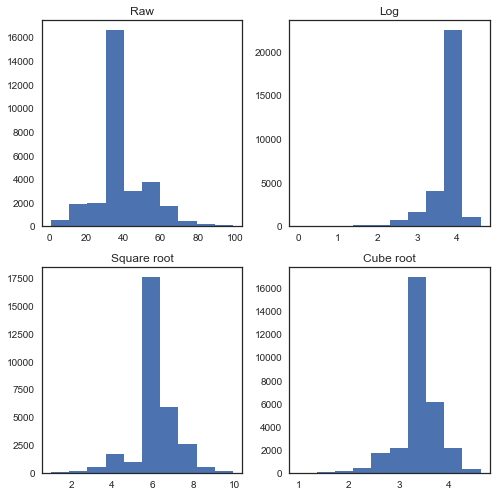

In [32]:
# Making a four-panel plot for each continuous variable
for col in ['age', 'hours_per_week']:
    print('\t\t*****Four-panel Plot for {}*****'.format(col))
    plt.figure(figsize=(7,7))
    
    plt.subplot(221)
    plt.hist(inc[col])
    plt.title('Raw')
    
    plt.subplot(222)
    plt.hist(np.log(inc[col]))
    plt.title('Log')
    
    plt.subplot(223)
    plt.hist(np.sqrt(inc[col]))
    plt.title('Square root')
    
    plt.subplot(224)
    plt.hist(inc[col]**(1/3))
    plt.title('Cube root')
    plt.tight_layout()
    plt.show()

According to the data, the log of age and the raw data for hours per week appear most normally distributed.  I will construct a new feature that is the log of the age of the person, and include the raw hours per week as a feature as well. 

In [33]:
# Constructing new features data frame
features = pd.DataFrame()
# Starting with target column
features['income'] = inc['income']
# Adding in new features 
features['log_age'] = np.log(inc['age'])
features['hours_per_week'] = inc['hours_per_week']

Now I need to address capital gains and capital losses.  I will engineer two features for these and then check to see which has more significant differences between higher or lower income values.  The two features will be net capital gains, where I will subtract capital losses from capital gains, and the I will turn this new feature into categories, including negative (capital losses), net neutral capital gains, positive capital gains, and highly positive capital gains. 

In [34]:
# Constructing Net Capital Gains feature
features['net_cap_gains'] = inc.capital_gain - inc.capital_loss

# Turning capital gains feature into categorical with negative, neutral, positive, and highly positive buckets
custom_buckets = [-5000, -1, 0, 5000, 100000]
features['net_cap_gains_cat'] = pd.cut(features.net_cap_gains, custom_buckets, 
                                       labels=['Neg','Neut','Postive', 'HighPositive'])
features.net_cap_gains_cat.value_counts()

Neut            26197
HighPositive     1566
Neg              1427
Postive           972
Name: net_cap_gains_cat, dtype: int64

Now that I've engineered new features for this data, I will return to exploring the data to ensure that there are significant differences in each feature  between the high and low income groups. 

					***** LOG_AGE *****


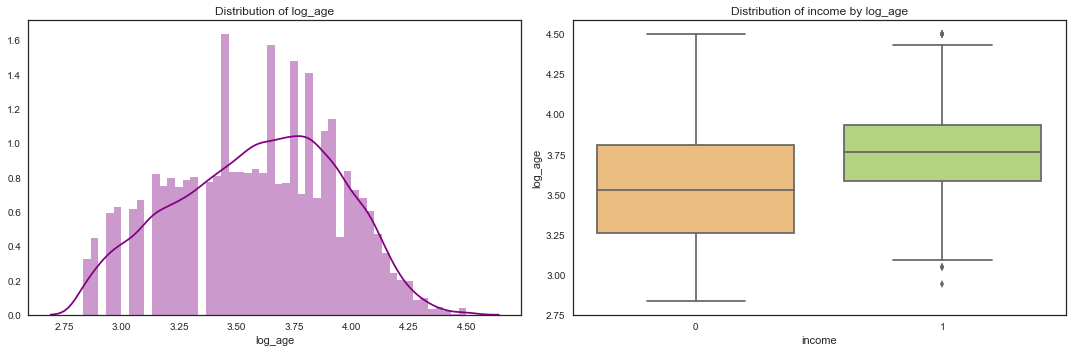

					***** HOURS_PER_WEEK *****


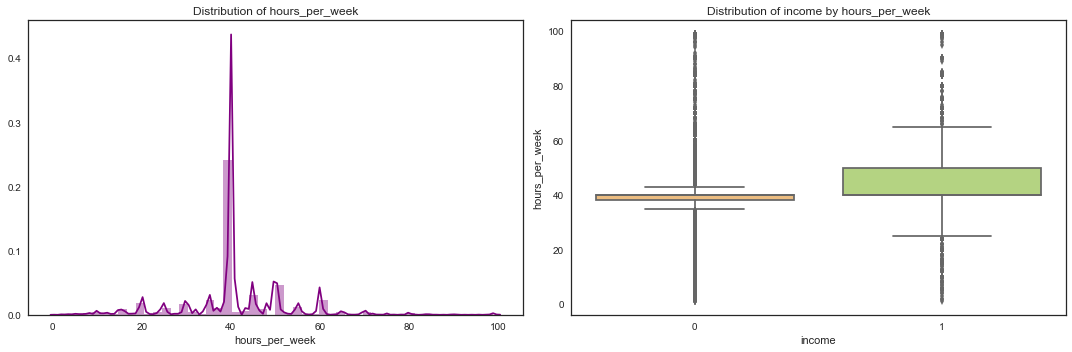

					***** NET_CAP_GAINS *****


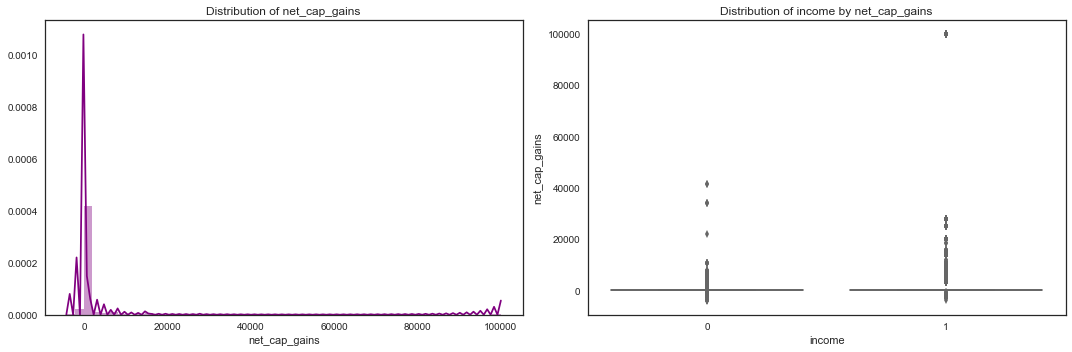

					***** NET_CAP_GAINS_CAT *****


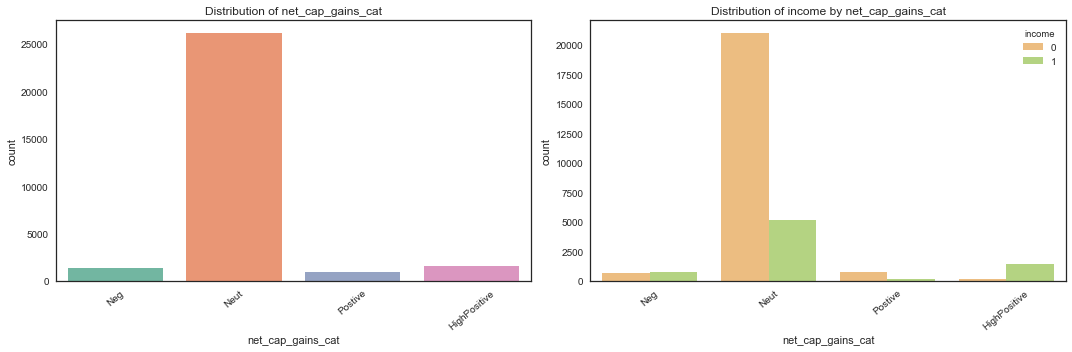

income                 0     1
net_cap_gains_cat             
Neg                  690   737
Neut               21021  5176
Postive              796   176
HighPositive         147  1419


,Attribute,P_value
0,log_age,0.000000e+00
1,hours_per_week,0.000000e+00
3,net_cap_gains_cat,0.000000e+00
2,net_cap_gains,1.775418e-304


In [35]:
# Initializing data frame for p-values from Chi-Square and t-tests
p_vals = pd.DataFrame(columns=['Attribute', 'P_value'])

for col in features.columns:
    # Constructing count plots for categorical data
    if col in features.select_dtypes(include='category').columns:
        print('\t\t\t\t\t***** {} *****'.format(col.upper()))
        # Plotting counts of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.countplot(x=col, data=features, palette='Set2')
        plt.title('Distribution of {}'.format(col))
        plt.xticks(rotation=40)

        # Plotting counts of each column by income level
        plt.subplot(122)
        sns.countplot(x=col, data=features, hue='income', palette='RdYlGn')
        plt.title('Distribution of income by {}'.format(col))
        plt.xticks(rotation=40)
    
        plt.tight_layout()
        plt.show()

        # Creating cross tabulated data for Chi-square test
        counttable = pd.crosstab(features[col], features['income'])
        print(counttable)
        chi2, p, dof, ex = chi2_contingency(counttable, correction=False)
        p_vals = p_vals.append({'Attribute':col, 'P_value':float(p)}, ignore_index=True)
    
    # Constructing histograms and boxplots for continuous data
    elif col in features.select_dtypes(include=['int64','float64']).columns.drop('income'):
        print('\t\t\t\t\t***** {} *****'.format(col.upper()))
        # Plotting distributions of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.distplot(features[col], color='Purple')
        plt.title('Distribution of {}'.format(col))

        # Plotting distributions of each column by income level
        plt.subplot(122)
        sns.boxplot(x='income', y=col, data=features, palette='RdYlGn')
        plt.title('Distribution of income by {}'.format(col))
    
        plt.tight_layout()
        plt.show()

        # Calculating pvalues from t-test
        t_val, p_val = ttest_ind(features[features['income']==0][col],
                                features[features['income']==1][col])
        p_vals = p_vals.append({'Attribute':col, 'P_value':float(p_val)}, ignore_index=True)
    

# Printing p-values of Chi-squared tests, sorted by p-values
p_vals.sort_values('P_value')

From this analysis, all of the p-values for the chi-square or t-tests are significant, with p-values of less than 0.05, and most p-values are 0.00.  Other insights from the data include:
- Log age is more normally distributed, and still has significant differences between the income of older and younger people.
- From the count plot for categorical capital gains, those people with highly positive capital gains are more likely to have an income of greater than \$50,000, and those with net negative capital gains have an about equal likelihood of having an income greater than \$50,000. These insights were hidden in the continuous data.  Additionally, the p-value for the categorical net capital gains is 0.00 whereas the p-value for the continuous data is still highly significant, but greater than 0.00.  For this reason, and based on the count plots, I should keep the categorical values of capital gains, and remove the continuous column.  

In [36]:
# Removing the continuous net capital gains column
features = features.drop('net_cap_gains', axis=1)

# Creating dummy columns for categorical net capital gains
dummies2 = pd.get_dummies(features.net_cap_gains_cat)
dummies2.head()

,Neg,Neut,Postive,HighPositive
0,0,0,1,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


Next, I need to ensure that the potential features are independent from one another.  To visualize and determine this independence between continuous variables, I will use a correlation matrix and heatmap.  

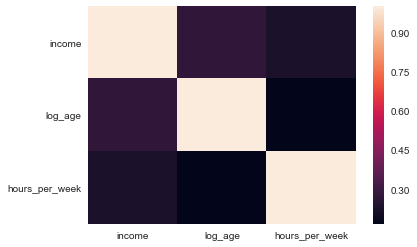

In [37]:
# Constructing Correlation Matrix
corrmat = features.corr()
# Setting up heatmap
sns.heatmap(corrmat)
plt.show()

This is great, according to the data, the continuous variables are independent from one another.  Most models assume that all features are independent from one another, which this confirms. Now I need to combine the features data frame with the two dummy data frames, then I will be ready for modeling!  

In [38]:
# Joining categorical and continuous features together in one data frame
features = pd.concat([features.drop('net_cap_gains_cat',axis=1), dummies, dummies2], axis=1)
features.head()

,income,log_age,hours_per_week,workclass_Government,workclass_Not_working,workclass_Private,workclass_Self_employed,education_Advanced-degree,education_Bachelors,education_Dropout,...,sex_Female,sex_Male,native_country_Asia,native_country_Europe,native_country_Latin_Am,native_country_United_States,Neg,Neut,Postive,HighPositive
0,0,3.663562,40,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,3.912023,13,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,0,3.637586,40,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,0,3.970292,40,0,0,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
4,0,3.332205,40,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0


## Modeling

Before beginning to model, I need to identify variables, and split the data into train and test sets for cross validation.  Because my analysis revealed that there were more people who earned over \$50,000 than under, I have a class imablance that could possibly skew the accuracy results of the modeling. I will under sample the training set to reduce the class imbalance in our target outcome. I will leave the test set as-is to ensure that I am testing the models on a fresh set of data.

In [39]:
# Identify variables
X = features.drop('income', axis=1)
y = features.income

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Under sampling 
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

print('Raw Training Set Percent Fraud: {:.1f}'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent Fraud: {}'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

Raw Training Set Percent Fraud: 24.9
Resampled Training Set Percent Fraud: 50.0


### Logistic Regression

To begin predicting whether a person's income is greater or less than \$50,000, I will start by using a logistic regression model.  This model will be useful because we can use the logged odds from the results of the model to be able to interpret the results into meaningful, actionable results.  

I will start by instantiating and fitting the model using default values.  I will fit the model using the training set, and then test the model's accuracy using the test set.  Because there is no real cost in improperly labeling a person as having an income of over or under \$50,000, I will use the default accuracy score to assess how well the model predicted the data.

In [40]:
# Instantiating and fitting logistic regression
print('Default Logistic Regression Model')
logR = LogisticRegression(random_state=42)
logR.fit(X_rus, y_rus)

# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_logR1 = cross_val_score(logR, X_rus, y_rus, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_logR1.mean(), 
                                                                                 scores_logR1.std()*2))
scores_logR1t = cross_val_score(logR, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_logR1t.mean(), 
                                                                                 scores_logR1t.std()*2))

Default Logistic Regression Model
Cross Validation Accuracy Scores - Training Set: 0.81631(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.85280(+/- 0.02)


This is a pretty good first model! The default values from logistic regression was able to explain the variance in 85 (+/- 2)% of the test set.  This is a fairly small range of two standard deviations from the mean, which means that the scores from the 10 folds of cross validation are all close together.  

#### Logistic Regression Optimization
Now, let's see if I can improve the overall accuracy of the model through optimizing the parameters by using Grid Search with cross validation. I will optimize the C, or the regularization parameter; the solver, which is the algorithm used in the optimization;, and the penalty, as L1 (LASSO) or L2 (Ridge) regression.  In each instance, I want to add an intercept to the decision function.

In [41]:
# Set of parameters to test in Grid Search
parameters = [{'C':[0.1,1,10,100,500,800], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100,500,800], 'solver':['newton-cg'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100,500,800,1000], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(logR, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

Best Score: 0.8171966601527803
Best Parameters: {'C': 100, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


It appears that this best score is approximately the same as the accuracy score from the default logistic regression model.  Using these new best parameters, let's fit another logistic regression model and test to see how these parameters in the model impact the training and test set accuracies. 

In [42]:
logR_g = LogisticRegression(**best_params, random_state=42)
logR_g.fit(X_rus, y_rus)

scores_logR_g = cross_val_score(logR_g, X_rus, y_rus, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_logR_g.mean(), 
                                                                                 scores_logR_g.std()*2))
scores_logR_gt = cross_val_score(logR_g, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_logR_gt.mean(), 
                                                                                 scores_logR_gt.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.81640(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.85307(+/- 0.01)


Wow! After optimization, the accuracy for the training set improved by 0.013%.  This doesn't seem like a lot, but it is still an improvement.  Let's take a look at what the coefficients and intercept values are for this model to then help us interpret what impacts the different demographic indicators have on income.  The logistic regression coefficients represent the log of the odds that the change in the feature makes.  To better interpret these values, I will take the exponentiated value of the coefficients to get the odds ratios of each piece of demographic data.

In [43]:
# Printing Logistic Regression Intercept
print('log(Intercept):', logR_g.intercept_)
print('Intercept:', np.exp(logR_g.intercept_))

# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(logR_g.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'log_Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Coef'] = np.exp(coefs_lg['log_Coef'])
print('Features with the most impact on higher income levels')
coefs_lg.sort_values('Coef', ascending=False).head(10)

log(Intercept): [-0.51976212]
Intercept: [0.59466199]
Features with the most impact on higher income levels


,Attribute,log_Coef,Coef
39,HighPositive,2.562355,12.966315
6,education_Advanced-degree,1.879541,6.550496
0,log_age,1.520791,4.575843
7,education_Bachelors,1.290012,3.632828
10,education_Some-college,0.477872,1.612638
36,Neg,0.074401,1.077239
9,education_HS-grad,0.059008,1.060784
1,hours_per_week,0.032733,1.033275
11,marital_status_Married,-0.472588,0.623387
29,race_White,-0.546092,0.579209


In [44]:
print('Features with the least impact on higher income levels')
coefs_lg.sort_values('Coef', ascending=True).head(5)

Features with the least impact on higher income levels


,Attribute,log_Coef,Coef
22,occupation_Priv-house-serv,-7.572855,0.000514
3,workclass_Not_working,-5.114101,0.006011
12,marital_status_Never-married,-3.132356,0.043615
18,occupation_Farming-fishing,-2.826565,0.059216
13,marital_status_No_longer_married,-2.703574,0.066966


According to the model, there are factors that have more or less impact on a peron's probability of earning more than \$50,000 a year.  The following are a sampling of what demographic traits impact a person's probability for higher income, along with the odds that that trait brings.  In this analysis, I will approximate over \$50,000 with having higher earnings.

__Improved Proabability for Higher Earnings__
- Having a highly positive capital gain gives you a 13 times higher probability for higher earnings, and having a net negative capital gains for the year gives you a 1.1 times higher probability for higher earnings.
- Earning an advanced degree brings a 6.5 times higher probability for higher earnings, whereas a Bachelors provides a 3.6 times higher probability for higher earnings.
- Every 10 years older a person becomes is related to a 4.6 times higher probability for higher earnings.

__Reduced Probability for Higher Earnings__
- Being in private house service gives you 0.0.0005 times higher probability for higher earnings, whereas being a farmer or fisherman gives you a 0.05 times higher probability for higher earnings, and not working means you have a 0.006 times higher probability for higher earnings.
- No longer being married gives you 0.06 times higher probability for higher earnings, whereas never being married means you have a 0.04 times higher probability for higher earnings.


### Support Vector Machine Classifier
Now that we have identified how some of the features impact a person's probability of earning over \$50,000 in a year, let's see if we can improve the accuracy of the predictions using a support vector machine classifier.  This model calculates the optimal hyperplane to categorize samples.

I again will start by instantiating and fitting the model using default values.  I will fit the model using the training set, and then test the model's accuracy using the test set. 

In [60]:
t0 = time.time()

In [61]:
#instantiating and fitting the model
svc = SVC(random_state=42)
svc.fit(X_rus, y_rus)

# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_svc = cross_val_score(svc, X_rus, y_rus, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_svc.mean(), 
                                                                                 scores_svc.std()*2))
scores_svct = cross_val_score(svc, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_svct.mean(), 
                                                                                 scores_svct.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.798(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.841(+/- 0.02)


In [62]:
t1 = time.time()
print('Time:', t1-t0)

Time: 69.77996015548706


These values of accuracy for the training and test sets are not quite as good as for the logistic regression model.  This was only for the default values of the SVC model. 

#### Support Vector Machine Classifier Optimization
Now, let's see if I can improve the overall accuracy of the model through optimizing the parameters by using Grid Search with cross validation. I will optimize the C, or the regularization parameter; the kernel, which specifies the higher dimension that the model uses to find the hyperplane;, and the gamma, which is how far the influence of a single training sample reaches from the hyperplane. 

In [63]:
t0 = time.time()

In [ ]:
# Set of parameters to test for best score in Grid Search CV
parameters = [{'kernel':['rbf'], 'C':[0.01,0.1,1,10], 'gamma':[1e-4, 1e-3, 1e-2]},
              {'kernel':['linear'], 'C':[0.01,0.1,1,10]},
             {'kernel':['poly'], 'C':[0.01,0.1,1,10], 'gamma':[1e-4, 1e-3, 1e-2]}]

#fitting model and printing best parameters and score from model
grid_svc = GridSearchCV(svc, param_grid=parameters)
grid_svc.fit(X_rus, y_rus)
print('Best Score:', grid_svc.best_params_)
best_params_svc = grid_svc.best_score_
print('Best Parameters:', best_params_svc)

In [ ]:
t1 = time.time()
print('Time:', t1-t0)

Now that we know what best parameters to use, let's use these parameters for a new SVC model and fit the model to the training data, then test the accuracy of the test set.

In [ ]:
t0 = time.time()

In [ ]:
#using best parameters to fit and test accuracy of train and test sets
svc2 = SVC(**best_params_svc, random_state=42)
svc2.fit(X_rus, y_rus)

# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_svc2 = cross_val_score(svc2, X_rus, y_rus, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_svc2.mean(), 
                                                                                 scores_svc2.std()*2))
scores_svc2t = cross_val_score(svc2, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_svc2t.mean(), 
                                                                                 scores_svc2t.std()*2))

In [ ]:
t1 = time.time()
print('Time:', t1-t0)

sflhslifgjsi FILL THIS IN HERE

### Random Forest Classifier
The last model I will use to predict what demographic indicators are related to higher incomes is the random forest classifier model.  This model creates a set of decision trees and then aggregates the votes from all of the decision trees to decide the class of the test case.  

I will again start by instantiating and fitting the model using default values.  I will fit the model using the training set, and then test the model's accuracy using the test set. 

In [48]:
#instantiating and fitting default model
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_rus, y_rus)

# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_rfc1 = cross_val_score(rfc, X_rus, y_rus, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_rfc1.mean(), 
                                                                      (scores_rfc1.std()*2)))
scores_rfc1t = cross_val_score(rfc, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_rfc1t.mean(), 
                                                                                 scores_rfc1t.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.786(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.830(+/- 0.01)


With the default settings of the Random Forest model, the accuracy on the test set was 83 (+/- 1)%.  This is 2 percent lower accuracy than the logistic regression models, but again this was from the default settings.  Now, let's try and improve that accuracy.

#### Random Forest Classifier Optimization
Now, let's see if I can improve the overall accuracy of the model through optimizing the parameters by using Grid Search with cross validation. I will optimize the number of estimators, meaning number of trees used to aggregate the class; the number of features used to consider the best split; the minimum samples split, which indicates the number of samples used to find a node; whether or not bootstrap samples are used; and the maximum depth of the trees, indicating how many branches the tree has. 

In [53]:
t0 = time.time()

In [54]:
# Set of parameters to serach through for best score in Grid Search CV
parameters = {'n_estimators':[10,100,500],
             'max_features':['auto', 'sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'bootstrap':[True, False],
             'max_depth':[4,5,6,7,8]}
# Instantiating and fitting Grid Search, then printing best score and best parameters
grid_rfc = GridSearchCV(rfc, param_grid=parameters, cv=5)
grid_rfc.fit(X_rus, y_rus)
print('Best Score:', grid_rfc.best_score_)
best_params_rfc = grid_rfc.best_params_
print('Best Parameters:', best_params_rfc)

Best Score: 0.8173743116006396
Best Parameters: {'bootstrap': False, 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 100}


In [55]:
t1 = time.time()
print('Time:', t1-t0)

Time: 1547.6342408657074


Now that we know what best parameters to use, let's use these parameters for a new random forest classifier model and fit the model to the training data, then test the accuracy of the test set.

In [59]:
#instantiating model with best parameters
rfc2 = RandomForestClassifier(**best_params_rfc, random_state=42)
rfc2.fit(X_rus, y_rus)

# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_rfc2 = cross_val_score(rfc2, X_rus, y_rus, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_rfc2.mean(), 
                                                                      scores_rfc2.std()*2))
scores_rfc2t = cross_val_score(rfc2, X_test, y_test, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rfc2t.mean(), 
                                                                      scores_rfc2t.std()*2))

Cross Validation Accuracy Scores - Training Set: 0.818(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.85121(+/- 0.02)


NOTE ABOUT INTERPRETATION OF MODEL

Might want feature importances here too, depending on fit of model


## Conclusion

For this capstone project, I wanted to build models that were able to predict if a person's income is over \$50,000 in a year based on their demographic information.  The demographic information I used and engineered to perform these predictions were age, the number of hours per week worked, if their net capital gains was highly positive, positive, negative, or neutral.  I also used a person's level of education, marital status, occupation, sex, working class, race, and native country.  Using these features, I created logistic regression models, support vector machine classifiers, and random forest models to predict whether a person would have an income of over \$50,000.  I found that the three biggest indicators of a person having a higher income were having capital either capital gains or capital losses, earning a degree, whether a Bachelor's and/or another advanced degree, and age.  This definitely supports the claims that I have given students that education is a great source of upward mobility.  Unsurprisingly, net highly positive capital gains were related to higher incomes, but what was surprising was the fact that net negative capital gains had a decent impact on earning more.  Because capital gains OR losses both require that a person has and uses some amount of disposable income investing in something, this makes sense because a person could have money to invest in the stock market, for example, but then they could lose money there.  This doesn't negate the fact that they had extra money to invest in the first place.  

SOME KIND OF NOTE ABOUT ACCURACIES OF MODELS AND THE BEST MODEL FOR THIS DATA